# Automatic derivative-free step estimation

This notebook contains some drafts of possible approaches to estimate reasonable derivative steps without
prior knowledge about the derivatives.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from autostep.strategies import dx_min_cut, dx_relative_evaluation_order
from autostep.numerical_derivatives import df_dx_numerical

In [2]:
def f(x):
#     return x * x * x - x * x + x - 5  # increasing derivative
#     return -x * x * x - x * x + x - 5  # decreasing derivative
    return np.sin(x) * np.exp(-x)  # non-monotonic case
#     return np.sin(x) + 1e14

def df_dx_exact(x):
#     return 3 * x * x - 2 * x + 1  # increasing derivative
#     return -3 * x * x - 2 * x + 1  # decreasing derivative
    return np.exp(-x) * (np.cos(x) - np.sin(x))  # non-monotonic case
#     return np.cos(x)

## Hard coded approach

This is the classical case. The proper step is estimated by trial and errors, changing the value of `num_of_points`.

In [3]:
x_initial = 0.0
x_final = 5.0
num_of_points = 15
dx = (x_final - x_initial) / num_of_points
x_domain = np.linspace(x_initial, x_final, num_of_points)

dx

0.3333333333333333

In [4]:
df_dx_analytical = df_dx_exact(x_domain)
df_dx_approx = df_dx_numerical(f, x_domain, dx)

assert len(df_dx_analytical) == len(df_dx_approx)

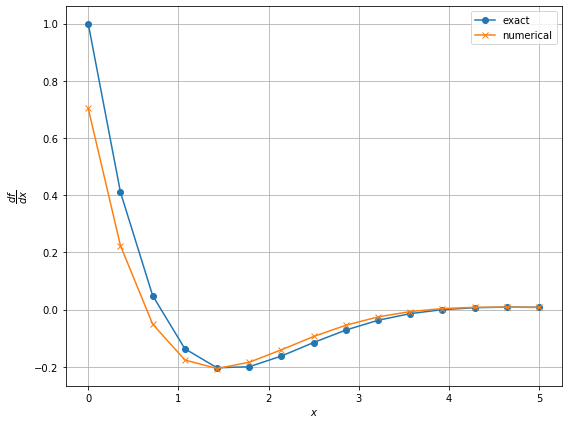

In [5]:
# NBVAL_IGNORE_OUTPUT
plt.figure(figsize=(8, 6))
plt.plot(x_domain, df_dx_analytical, "o-", label='exact')
plt.plot(x_domain, df_dx_approx, "x-", label='numerical')
plt.grid(True)
plt.legend()

plt.xlabel(r"$x$")
plt.ylabel(r"$\dfrac{d f}{d x}$")

plt.tight_layout()
plt.show()

## Automatic step size

The only prior knowledge required is a record of function evaluations.

In [6]:
f_evaluations = f(x_domain)

### Approach 1: step size relative to the norm of the absolute minimum value of the function

In [7]:
# NBVAL_IGNORE_OUTPUT
dx1 = dx_relative_evaluation_order(f_evaluations)

dx1

2.6804989082884456e-05

**REMARK:**

This approach is not suitable when `x_final - x_initial < 1`. Solutions are under investigations! Suggestions are welcome!

### Approach 2: minimum difference among all function evaluations recorded

In [8]:
# NBVAL_IGNORE_OUTPUT
dx2 = dx_min_cut(f_evaluations)

dx2

3.2537217119283236e-05

## Comparing the results

In [9]:
df_dx_analytical = df_dx_exact(x_domain)
df_dx_approx1 = df_dx_numerical(f, x_domain, dx1)
df_dx_approx2 = df_dx_numerical(f, x_domain, dx2)

assert len(df_dx_analytical) == len(df_dx_approx1) == len(df_dx_approx2)

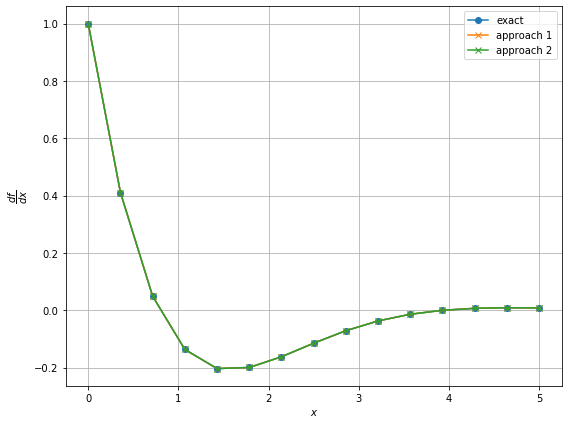

In [10]:
# NBVAL_IGNORE_OUTPUT
plt.figure(figsize=(8, 6))
plt.plot(x_domain, df_dx_analytical, "o-", label='exact')
plt.plot(x_domain, df_dx_approx1, "x-", label='approach 1')
plt.plot(x_domain, df_dx_approx2, "x-", label='approach 2')
plt.grid(True)
plt.legend()

plt.xlabel(r"$x$")
plt.ylabel(r"$\dfrac{d f}{d x}$")

plt.tight_layout()
plt.show()